# Clustering NYC schools, by student demographic

In this notebook, we will apply K-means clustering to NYC schools to see which are similar in demographic composition. The clustering could be used to expand analyses of other key education metrics, such as test scores, graduation rates, or chronic absenteeism, and explore whether trends emerge within these clusters.

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Data cleanup

In [2]:
cols_to_use = [ "DBN", "School Name", "Year", "Total Enrollment", "% Asian and Pacific Islander", "% Black", "% Hispanic",
               "% Multi-Racial", "% Native American", "% White", "% Missing Race/Ethnicity Data" ]
df = pd.read_excel("data/demographic-snapshot-2020-21-to-2024-25-public.xlsx", sheet_name="School", usecols=cols_to_use)

In [3]:
# add borough information
df["Borough"] = df["DBN"].str.extract(r"([A-Z])")

In [4]:
df_2024 = df[df["Year"] == "2024-25"].copy()
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1900 entries, 4 to 9372
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DBN                            1900 non-null   object 
 1   School Name                    1900 non-null   object 
 2   Year                           1900 non-null   object 
 3   Total Enrollment               1900 non-null   int64  
 4   % Asian and Pacific Islander   1900 non-null   float64
 5   % Black                        1900 non-null   float64
 6   % Hispanic                     1900 non-null   float64
 7   % Multi-Racial                 1900 non-null   float64
 8   % Native American              1900 non-null   float64
 9   % White                        1900 non-null   float64
 10  % Missing Race/Ethnicity Data  1900 non-null   float64
 11  Borough                        1900 non-null   object 
dtypes: float64(7), int64(1), object(4)
memory usage: 193.

## Clustering

In [5]:
# columns we will base the clusters on
features = [ "% Asian and Pacific Islander", "% Black", "% Hispanic", 
            "% Multi-Racial", "% Native American", "% White", "% Missing Race/Ethnicity Data" ]

In [6]:
inertias = []

In [7]:
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_2024[features])
    inertias.append(kmeans.inertia_)

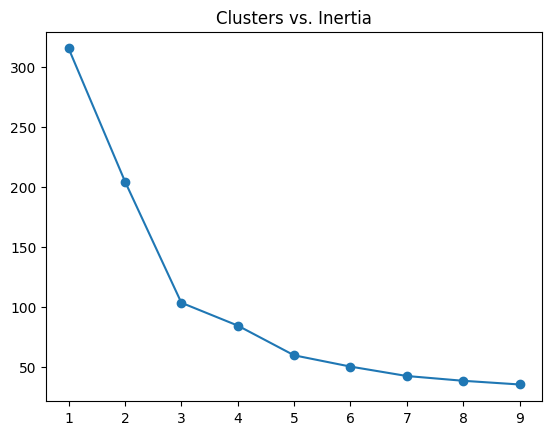

In [8]:
plt.plot(range(1, 10), inertias, marker="o")
plt.title("Clusters vs. Inertia")
plt.show()

From this graph, we can see that it starts to flatten at 5.

In [9]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_2024[features])

KMeans(n_clusters=5, random_state=42)

In [10]:
df_2024["kmeans_label"] = kmeans.labels_

## Exploring the clusters

In [11]:
df_2024["kmeans_label"].value_counts()

kmeans_label
1    537
2    479
3    396
4    300
0    188
Name: count, dtype: int64

In [12]:
feature_ave = df_2024.groupby("kmeans_label")[features].mean().T
feature_ave.style.format("{:.1%}")

kmeans_label,0,1,2,3,4
% Asian and Pacific Islander,51.4%,6.0%,4.7%,3.7%,17.6%
% Black,6.7%,31.8%,12.2%,66.5%,8.6%
% Hispanic,26.7%,53.7%,77.3%,23.1%,25.6%
% Multi-Racial,2.0%,1.3%,0.7%,1.4%,4.9%
% Native American,2.4%,1.3%,0.8%,1.6%,0.6%
% White,10.6%,5.5%,3.9%,3.1%,42.4%
% Missing Race/Ethnicity Data,0.1%,0.4%,0.3%,0.4%,0.4%


What I'm seeing here is that:
* Cluster 0: at least half the students are Asian/Pacific Islander (51.4%), significant Hispanic population (26.7%)
* Cluster 1: at least half the students are Hispanic (53.7%), significant Black population (31.8%)
* Cluster 2: majority Hispanic (77.3%)
* Cluster 3: majority Black (66.5%)
* Cluster 4: predominantly white (42.4%), with a significant Hispanic (25.6%) and Asian/Pacific Islander (17.6%) populations

In [13]:
df_2024.sample(3)

,DBN,School Name,Year,Total Enrollment,% Asian and Pacific Islander,% Black,% Hispanic,% Multi-Racial,% Native American,% White,% Missing Race/Ethnicity Data,Borough,kmeans_label
6013,26Q186,P.S. 186 Castlewood,2024-25,317,0.422713,0.126183,0.236593,0.041009,0.015773,0.157729,0.0,Q,0
3363,13K594,Gotham Professional Arts Academy,2024-25,223,0.022422,0.695067,0.215247,0.013453,0.013453,0.040359,0.0,K,3
7399,31R056,P.S. 56 The Louis Desario School,2024-25,643,0.174184,0.010886,0.136858,0.015552,0.003110,0.659409,0.0,R,4


In [14]:
import os
os.makedirs("output", exist_ok=True)
df_2024.to_csv("output/clustered-2024.csv", encoding="UTF-8", index=False)